# Регрессия на основе гауссовских процессов #

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Методы-восстановления-регрессии" data-toc-modified-id="Методы-восстановления-регрессии-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Методы восстановления регрессии</a></span></li><li><span><a href="#Регрессия-на-основе-гауссовских-процессов" data-toc-modified-id="Регрессия-на-основе-гауссовских-процессов-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Регрессия на основе гауссовских процессов</a></span><ul class="toc-item"><li><span><a href="#Формулы" data-toc-modified-id="Формулы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Формулы</a></span></li><li><span><a href="#Реализация" data-toc-modified-id="Реализация-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Реализация</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Обучающая-выборка-без-шума" data-toc-modified-id="Обучающая-выборка-без-шума-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обучающая выборка без шума</a></span></li></ul></li><li><span><a href="#Обучающая-выборка-с-шумом" data-toc-modified-id="Обучающая-выборка-с-шумом-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучающая выборка с шумом</a></span></li><li><span><a href="#Литература" data-toc-modified-id="Литература-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Литература</a></span></li></ul></div>

In [5]:
# Imports
import sys
import numpy as np
import numpy.linalg as LA
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [4]:
# Styles, fonts
sns.set_style('whitegrid')
matplotlib.rcParams['font.size'] = 12

---

## Методы восстановления регрессии ##

> Поскольку гауссовские процессы моделируют распределение функций, мы можем использовать их для построения регрессионных моделей.
Гауссовский процесс можно рассматривать как предварительно определённый функцией ядра и создать апостериорное распределение с учетом некоторых данных.
Это заднее распределение затем может быть использовано для прогнозирования ожидаемого значения и вероятности выходной переменной $\mathbf{y}$ данных входных переменных $X$.

В методах обучения с учителем мы часто используем *параметрические модели* $p(\mathbf{y} \lvert \mathbf{X},\boldsymbol\theta)$ для аппроксимации данных и нахождения оптимальных значений параметра $\boldsymbol\theta$ с помощью метода максимального правдоподобия или метода оценки апостериорного максимума.
С ростом сложности данных для построения хорошей аппроксимации обычно требуются модели с большим количеством параметров. Методы, использующие модели с фиксированным количеством параметров, называются параметрическими методами.

Другим подходом является использование *непараметрических методов*, где количество параметров зависит от размера набора данных. Например, в ядерной регрессии Надарая&ndash;Уотсона (Nadaraya&ndash;Watson kernel regression) каждому наблюдаемому отклику $y_i$ присваивается вес $w_i$, а для предсказания целевого значения в новой точке $\mathbf{x}$ вычисляется средневзвешенное значение: 

$$f(\mathbf{x}) = \sum_{i=1}^{N}w_i(\mathbf{x})y_i$$

$$w_i(\mathbf{x}) = \frac{\kappa(\mathbf{x}, \mathbf{x}_{i})}{\sum_{i'=1}^{N}\kappa(\mathbf{x}, \mathbf{x}_{i'})}$$

Чем ближе наблюдаемые точки к $\mathbf{x}$, тем больше их вес. Веса зависят от $\mathbf{x}$ и наблюдаемых $\mathbf{x}_i$, а функция зависимости называется ядром $\kappa$. Примером является метод KNN (k-nearest neighbors), где $k$ самых близких наблюдений имеют вес $1/k$, а все остальные &mdash; $0$. Обычно, для вычисления прогноза непараметрические методы должны обрабатывать все обучающие данные и поэтому работают медленнее, чем параметрические методы. С другой стороны, само обучение обычно происходит быстро, так как непараметрическим моделям нужно только запомнить обучающие данные. 

Другим примером непараметрических методов являются Гауссовские процессы (GP). Вместо того, чтобы делать выводы о распределении параметров параметрической функции, GP могут быть использованы для прямого вывода о распределении функций. GP определяет априорное распределение над функциями. После наблюдения за некоторыми значениями функции он может быть преобразован в апостериорную рапределение функций. Определение функции в этом контексте называется регрессией на основе GP.

---

## Регрессия на основе гауссовских процессов ##
(*Зайцев, стр. 33*)

В регрессии на основе гауссовских процессов предполагается, что заданная выборка значений целевой функции является реализацией гауссовского процесса и ковариационная функция процесса зависит только от взаимного расположения точек в пространстве.
Апостериорное среднее гауссовского процесса в новой точке используется для прогноза целевой функции в этой точке, а апостериорная дисперсия используется в качестве оценки неопределённости прогноза.

Обычно предполагают, что ковариационная функция гауссовского процесса лежит в параметрическом семействе.
Тогда задание регрессионной модели эквивалентно выбору параметров ковариоционной функции. Для оценки параметров используют метод максимального правдоподобия и байесовские методы, особенно эффективные в случае наличия априорных знаний о модели.

### Формулы ###

Вспомним выражения для условного распределение Гаусса. 

Мы хотим делать прогнозы $\mathbf{y}_2 = f(X_2)$ для новых образцов на $n_2$, и мы хотим делать эти прогнозы, основываясь на нашем гаусском процессе и $n_1$ ранее наблюдаемых точках данных $(X_1,\mathbf{y}_1)$. Это можно сделать с помощью заднего распределения $p(\mathbf{y}_2 \mid \mathbf{y}_1,X_1,X_2)$. Имейте в виду, что $\mathbf{y}_1$ и $\mathbf{y}_2$ являются гауссовыми, поскольку оба они должны иметь одну и ту же функцию. Поскольку они являются гауссовыми и у нас есть ограниченное количество примеров, мы можем их написать:

$$
\left[\begin{array}{c} \mathbf{y}_{1} \\ \mathbf{y}_{2} \end{array}\right]
\sim
\mathcal{N} \left(
\left[\begin{array}{c} \mu_{1} \\ \mu_{2} \end{array}\right],
\left[ \begin{array}{cc}
\Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22}
\end{array} \right]
\right)
$$

Здесь:
$$
\begin{split}
    \mu_{1}     & = m(X_1)                        \quad & (n_1 \times 1) \\
    \mu_{2}     & = m(X_2)                        \quad & (n_2 \times 1) \\
    \Sigma_{11} & = k(X_1,X_1)                    \quad & (n_1 \times n_1) \\
    \Sigma_{22} & = k(X_2,X_2)                    \quad & (n_2 \times n_2) \\
    \Sigma_{12} & = k(X_1,X_2)                    \quad & (n_1 \times n_2) \\
    \Sigma_{21} & = k(X_2,X_1) = \Sigma_{12}^\top \quad & (n_2 \times n_1)
\end{split}
$$

Для простоты положим $\mu_{1} = 0$ и $\mu_{2} = 0$. Тогда для условного распределения получим

$$
p(\mathbf{y}_2 \mid \mathbf{y}_1) = \mathcal{N}(\mu_{2|1}, \Sigma_{2|1}), \\
\begin{split}
    \mu_{2|1}    & = \Sigma_{21} \Sigma_{11}^{-1} \mathbf{y}_1 \\
    \Sigma_{2|1} & = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1}\Sigma_{12}
\end{split}
$$

Затем можно предсказать $\mathbf{y}_2$, соответствующий входным выборкам $X_2$, используя среднее значение $\mu_{2|1}$ результирующего распределения в качестве прогноза. 
Обратите внимание, что среднее апостериорных прогнозов $\mu_{2|1}$ гаусского процесса являются средневзвешенными значениями наблюдаемых переменных $\mathbf{y}_1$, где взвешивание основано на функции покрытия $k$. Разница между этими прогнозами составляет $\sigma_2^2$ и диагонали ковариационной матрицы $\Sigma_{2|1}$.

### Реализация ###

Как обычно, мы будем использовать квадратичное экспоненциальное ядро:

$$ k(x_a, x_b) = \sigma_f^2 \exp{ \left( -\frac{1}{2l^2} \lVert x_a - x_b \rVert^2 \right) }. $$

Ниже приводятся функции `kernel()`, `plot_gp()` и `posterior_predictive()`.

In [6]:
# Isotropic squared exponential kernel.
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes
    a covariance matrix from points in X1 and X2
    
    Args:
        X1: Array of m points (m x d)
        X2: Array of n points (n x d)

    Returns:
        Covariance matrix (m x n)
    '''
    
    sqdist = np.sum(X1**2,1).reshape(-1,1) + np.sum(X2**2,1) - 2*np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [12]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 2. * np.sqrt(np.diag(cov))
    
    plt.figure(figsize=(8,5))
    plt.fill_between(
        X, mu + uncertainty, mu - uncertainty,
        color='grey', alpha=0.1, label='95% доверительный интервал')
    plt.plot(X, samples, '-', lw=1.0)
    plt.plot(X, mu, 'k', label='среднее значение')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'kx', mew=1.5)
    plt.xlim([X.min(), X.max()])
    plt.ylim([-3, 3])
    plt.xlabel('$t$')
    plt.ylabel('$f(t)$')
    plt.legend(loc='lower right')

In [22]:
def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffiсient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s
    
    Args:
        X_s: New input locations (n x d)
        X_train: Training locations (m x d)
        Y_train: Training targets (m x 1)
        l: Kernel length parameter
        sigma_f: Kernel vertical variation parameter
        sigma_y: Noise parameter
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n)
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = LA.inv(K)
    
    # mean vector
    mu_s = K_s.T @ K_inv @ Y_train

    # covariance matrix
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    
    return mu_s, cov_s

## Тестирование ##

### Обучающая выборка без шума ###

Приведенный ниже код вычисляет заднее распределение на основе 8 наблюдений синусоидальной функции. Результаты представлены ниже. На верхнем рисунке показано распределение, где красной линией является задняя средняя, серой зоной &mdash; интервал предсказания 95%, черными точками &mdash; наблюдения $(X_1,\mathbf{y}_1)$.
Интервал прогнозирования вычисляется из стандартного отклонения $\sigma_{2|1}$, которое представляет собой квадратный корень диагонали ковариационной матрицы. На нижнем рисунке показано 5 реализаций (выборочных функций) из этого распределения.

Отметим, что неуверенность в точках, прогнозируемых вокруг наблюдений $(X_1,\mathbf{y}_1)$, достаточно велика, и что чем дальше от этих точек, тем больше интервал прогнозирования.

и применять их к бесшумным тренировочным данным `X_train` и `Y_train`. Следующий пример рисует три образца из заднего прогноза и строит диаграммы вместе со средним значением, доверительным интервалом и тренировочными данными. В бесшумной модели дисперсия на тренировочных точках равна нулю, и все случайные функции, взятые из апостериорного прогноза, проходят через тренировочные точки. 

In [40]:
A = np.array([1, 5])
B = np.array([[1, 5],[5, 1]])
C = np.array([1, 5]).T
print(LA.inv(B))
print(A @ LA.inv(B) @ C)

[[-0.04166667  0.20833333]
 [ 0.20833333 -0.04166667]]
0.9999999999999999


In [20]:
# Data
x_min, x_max = 0., 10.
N_test = 1001
X_test = np.linspace(x_min, x_max, N_test).reshape(-1,1)

X_train = np.array([2.,  6.,  7., 8.,  4., 3. ]).reshape(-1, 1)
Y_train = np.array([1., -1., -1., 0.5, 1., 0.5]).reshape(-1, 1)

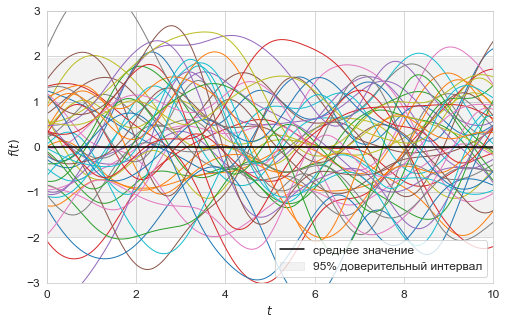

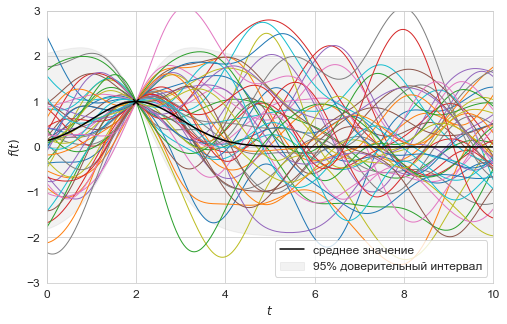

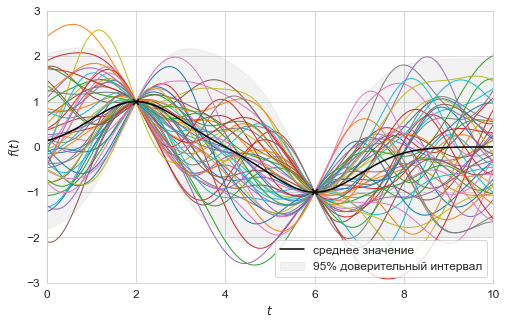

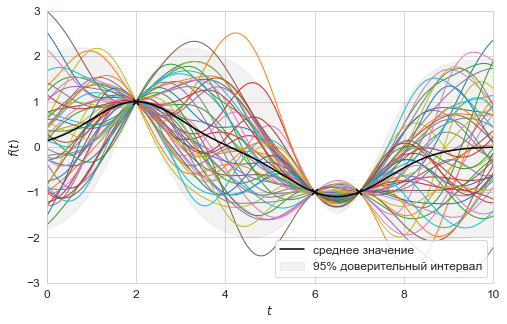

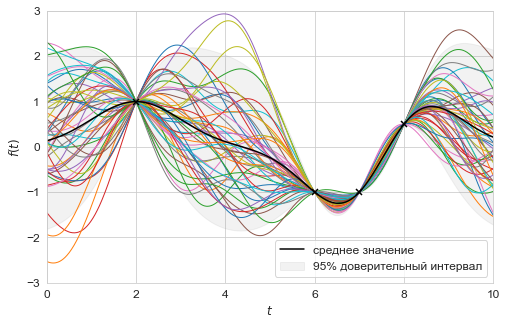

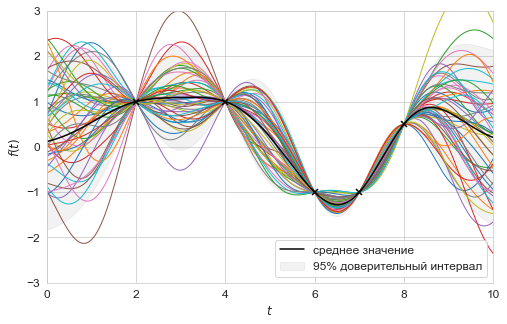

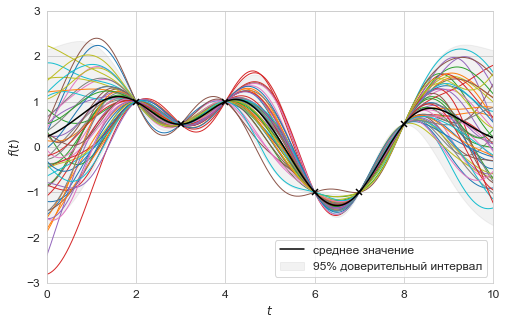

In [23]:
N_gp_post = 50

for i in range(len(X_train)+1):
    x_train_i = X_train[:i]
    y_train_i = Y_train[:i]
    
    # Compute mean and covariance of the posterior predictive distribution
    mu_s, cov_s = posterior_predictive(X_test, x_train_i, y_train_i)
    
    # Generate samples from the prior
    gp_post = np.random.multivariate_normal(mu_s.ravel(), cov_s, N_gp_post).T
    
    # Draw samples from the prior
    plot_gp(mu_s, cov_s, X_test, X_train=x_train_i, Y_train=y_train_i, samples=gp_post)
#     plt.savefig(f'gp_{i}.png')

На рисунках видно, что точки обучающей выборки как будто &laquo;захватывают&raquo; наши процессы в узкие пучки.

Получим выражения для первых двух кривых в явном виде:

1. $ f(x | x_1, y_1) = y_1 \cdot e^{-\frac{1}{2}(x-x_1)^2} = e^{-\frac{1}{2}(x-2)^2}$

2. учитывая, что $ k_{12} = e^{-\frac{1}{2}(x_2 - x_1)^2} = e^{-\frac{1}{2}(6 - 2)^2} = 3.4 \cdot 10^{-4} \approx 0 $,  
получим $ f(x | x_1, y_1, x_2, y_2) \approx y_1 \cdot e^{-\frac{1}{2}(x-x_1)^2} + y_2 \cdot e^{-\frac{1}{2}(x-x_2)^2} = e^{-\frac{1}{2}(x-2)^2} - e^{-\frac{1}{2}(x-6)^2} $

## Обучающая выборка с шумом ##

Если в модель включен некоторый шум, то учебные точки являются только приблизительными, а дисперсия на учебных точках ненулевая.

А что, если мы не на 100 % уверены в наших точках? То есть значения, через которые мы проводим процессы, измерены с какой-то точностью. Тогда &laquo;пучки&raquo; можно делать не такими узкими.

The predictions made above assume that the observations $f(X_1) = \mathbf{y}_1$ come from a noiseless distribution. We can notice this in the plot above because the posterior variance becomes zero at the observations $(X_1,\mathbf{y}_1)$.
We can make predictions from noisy observations $f(X_1) = \mathbf{y}_1 + \epsilon$, by modelling the noise $\epsilon$ as Gaussian noise with variance $\sigma_\epsilon^2$.

Приведенные выше прогнозы предполагают, что наблюдения $f(X_1) = \mathbf{y}_1$ происходят из бесшумного распределения. Это можно заметить на приведенном выше графике, так как при наблюдениях $(X_1,\mathbf{y}_1)$ задняя дисперсия становится равной нулю.
Прогнозировать можно по шумным наблюдениям $f(X_1) = \mathbf{y}_1 + \epsilon$, смоделировав шум $\epsilon$ как гауссов шум с дисперсией $\sigma_\epsilon^2$.

This noise can be modelled by adding it to the covariance kernel of our observations:

Этот шум можно смоделировать, добавив его в ковариационное ядро наших наблюдений:

$$
\Sigma_{11} = k(X_1,X_1) + \sigma_\epsilon^2 I
$$

Where $I$ is the identity matrix. Note that the noise only changes kernel values on the diagonal (white noise is independently distributed). The Gaussian process posterior with noisy observations is implemented in the `GP_noise` method below.

Где $I$ &mdash; это идентификационная матрица. Обратите внимание, что шум изменяет только значения ядра по диагонали (белый шум распределяется независимо). Гауссовский процесс задней части с шумовыми наблюдениями реализован методом `GP_noise`, описанным ниже.

Приведенный ниже код вычисляет заднее распределение предыдущих 5 образцов с добавленным шумом. Обратите внимание на график, что дисперсия $\sigma_{2|1}^2$ на наблюдениях больше не равна 0, и что функции, отобранные в выборке, больше не обязательно должны проходить через эти точки наблюдения.

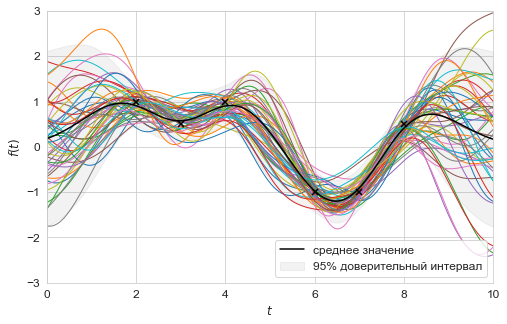

In [15]:
N_gp_post = 50
sigma_y = 0.25
    
# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X_test, X_train, Y_train, sigma_y=sigma_y)

# Generate samples from the prior
gp_post = np.random.multivariate_normal(mu_s.ravel(), cov_s, N_gp_post).T

# Draw samples from the prior
plot_gp(mu_s, cov_s, X_test, X_train=x_train_i, Y_train=y_train_i, samples=gp_post)

## Литература

1. Roelants P. [Understanding Gaussian processes](https://peterroelants.github.io/posts/gaussian-process-tutorial/).
1. Krasser M. [Gaussian_processes]().
1. Зайцев А.А. Методы построения регрессионных моделей разнородных источников данных для индустриальной инженерии // PhD Thesis. ИППИ РАН, 2017. 148 с.